# Libs

In [50]:
import numpy as np 
import pandas as pd 
import cv2
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob

# Dowload and process data

In [ ]:
#to download data from Kaggle, go to your account and dowload the kaggle.json file, then put it in the .kaggle directory.
#finally, execute this command
#import kaggle
#!kaggle competitions download -c deep-learning-competition-cs-2020

#zip the file
#import zipfile
#with zipfile.ZipFile("deep-learning-competition-cs-2020.zip", 'r') as zip_ref:
#    zip_ref.extractall("kaggle_data")

In [9]:
#explore the data directory
root_dir = 'kaggle_data'
import os
for dirname, _, filenames in os.walk(root_dir):
    print(dirname) 

kaggle_data
kaggle_data\test
kaggle_data\test\test
kaggle_data\train
kaggle_data\train\train
kaggle_data\train\train\COVID19 AND PNEUMONIA
kaggle_data\train\train\NORMAL


In [10]:
#config gPU
#config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56}, log_device_placement=True ) 
#sess = tf.compat.v1.Session(config=config)

In [27]:
#define data directories

#train data location that you dowloaded from Kaggle
input_data_dir = './kaggle_data/train/train'

#test data location that you dowloaded from Kaggle (this data has no labels, it's used for Kaggle competition)
input_test_dir = './kaggle_data/test/test'

#dir where you want to put train/val/test data
train_val_test_dir = './train_val_test'

In [28]:
#split train/train folder into data/train and data/val folders, and use oversampling for data imbalance
import splitfolders
#see split_folders documentation
#500 samples for validation and 400 samples for testing
splitfolders.fixed(input=input_data_dir, output=train_val_test_dir, seed=1337, fixed=(500, 400), oversample = True)

#in case you dont want to use oversampling, split data into ratios of train and val
#splitfolders.ratio(input=input_data_dir, output=train_val_dir, seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 370 files [00:01, 60.97 files/s]



Copying files: 5266 files [01:54, 45.97 files/s] A
Copying files: 0 files [02:43, ? files/s]/s]
Oversampling: 2 classes [02:00, 60.17s/ classes]


In [29]:
#see the new directory containing train, val and test data
for dirname, _, filenames in os.walk(train_val_test_dir):
    print(dirname) 

./train_val_test
./train_val_test\test
./train_val_test\test\COVID19 AND PNEUMONIA
./train_val_test\test\NORMAL
./train_val_test\train
./train_val_test\train\COVID19 AND PNEUMONIA
./train_val_test\train\NORMAL
./train_val_test\val
./train_val_test\val\COVID19 AND PNEUMONIA
./train_val_test\val\NORMAL


In [30]:
# Input data file
train_path = os.path.join(train_val_test_dir, 'train')
train_normal_path = os.path.join(train_path, 'NORMAL')
train_covid_path = os.path.join(train_path, 'COVID19 AND PNEUMONIA')

val_path = os.path.join(train_val_test_dir, 'val')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_covid_path = os.path.join(val_path, 'COVID19 AND PNEUMONIA')

test_path = os.path.join(train_val_test_dir, 'test')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_covid_path = os.path.join(test_path, 'COVID19 AND PNEUMONIA')

In [31]:
# # Plot the Images:
def plot_images(item_dir, n=6):
    all_item_dir = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dir][:n]
    
    plt.figure(figsize=(35, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(2, n, idx+1)
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()

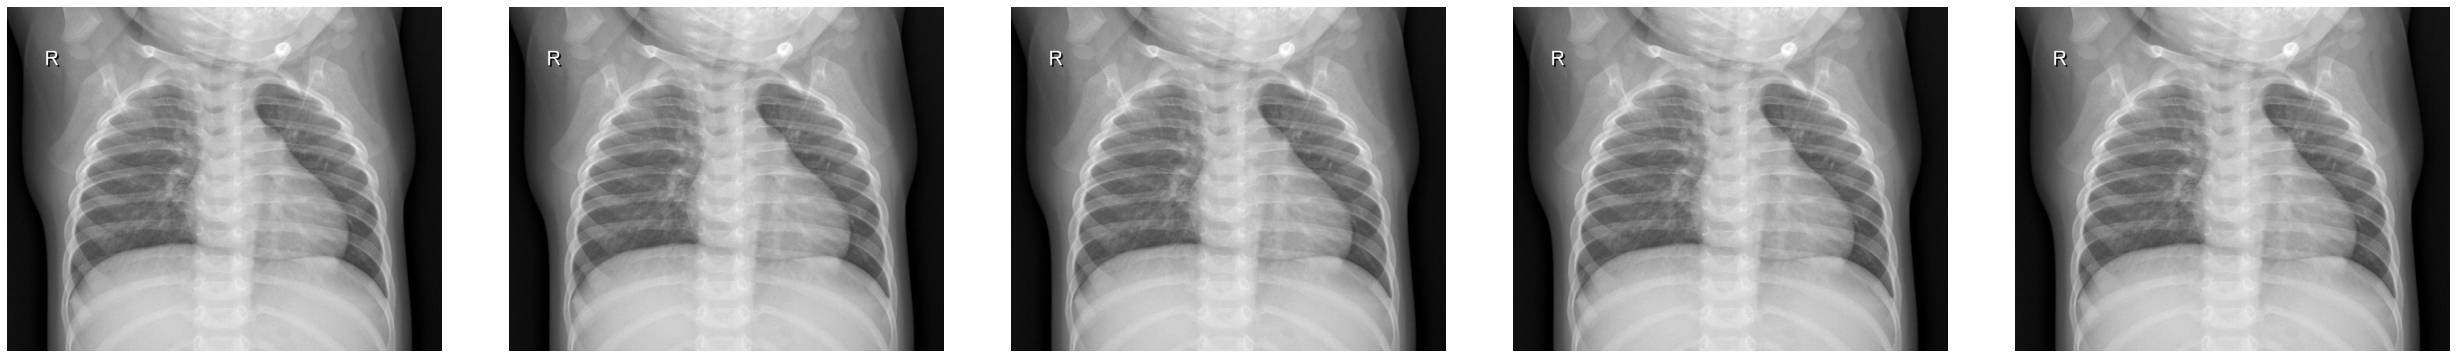

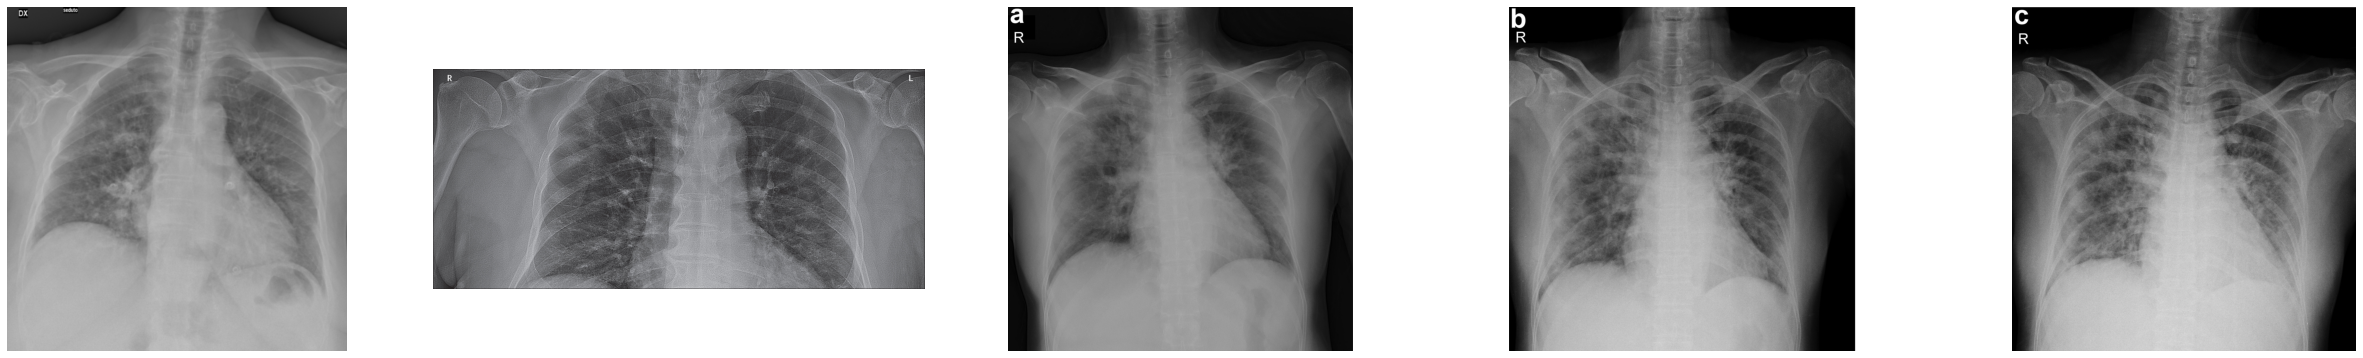

In [34]:
plot_images(train_normal_path, 5)
plot_images(train_covid_path, 5)

In [36]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)
    

In [37]:
Images_details(train_normal_path)
Images_details(train_covid_path)

 ====== Images in:  ./train_val_test\train\NORMAL
images_count:	3025
min_width:	912
max_width:	2663
min_height:	672
max_height:	2663
 ====== Images in:  ./train_val_test\train\COVID19 AND PNEUMONIA
images_count:	3025
min_width:	256
max_width:	3520
min_height:	132
max_height:	3520


# Prepare data (in batches)

In [39]:
def process_data(img_dims, batch_size):
    # Data generation objects - thorugh rescalling, veticle flip, zoom range ...
    train_datagen = ImageDataGenerator(
                        rescale = 1./255,
                        #featurewise_center=True,
                        #featurewise_std_normalization=True,
                        zoom_range = 0.3,
                        vertical_flip = True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2, 
    )
    
    val_datagen = ImageDataGenerator(
                      #  featurewise_center=True,
                      #  featurewise_std_normalization=True,
                        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
                                directory = train_path, 
                                target_size = (img_dims, img_dims), 
                                batch_size = batch_size, 
                                class_mode = 'categorical', 
                                shuffle=True)

    val_gen = val_datagen.flow_from_directory(
                                directory=val_path, 
                                target_size=(img_dims, img_dims), 
                                batch_size=batch_size, 
                                class_mode='categorical', 
                                shuffle=True)
    
    
    # Making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/COVID19 AND PNEUMONIA/']:
        for img in (os.listdir(test_path + cond)):
            try:
                img = cv2.imread(test_path + cond + img)
            except:
                print("Image corrupted.")
                continue
            img = cv2.resize(img, (img_dims, img_dims))
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/COVID19 AND PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    
    # Prepare test data for Kaggle
    img_names_kaggle=[]
    test_imgs_kaggle=[]

    for img in os.listdir(input_test_dir):
        img_path = os.path.join(input_test_dir, img)
        try:
            image = cv2.imread(img_path)
        except:
            print("Image corrupted.")
            continue
        image = cv2.resize(image, (img_dims,img_dims))
        image = image.astype('float32') / 255
        img_names_kaggle.append(img)
        test_imgs_kaggle.append(image)
    test_imgs_kaggle=np.array(test_imgs_kaggle)
    
    return train_gen, val_gen, test_data, test_labels,  test_imgs_kaggle, img_names_kaggle

In [40]:
# Hyperparameters
img_dims = 128
epochs = 30
batch_size = 64

In [43]:
# Getting the data
train_gen, test_gen, test_data, test_labels, test_imgs_kaggle, img_names_kaggle = process_data(img_dims, batch_size)

Found 6050 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Create and train MobileNet model

In [45]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [46]:
#MobileNet model initialized with imagnet dataset
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, 
                                             input_shape=(img_dims, img_dims, 3))

output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation='softmax')(output)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
#Train
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size,
           callbacks=[checkpoint, lr_reduce])

17227776/17225924 [==============================] - 1s 0us/step
Epoch 1/30
134/134 [==============================] - 171s 1s/step - loss: 0.2327 - accuracy: 0.9355 - val_loss: 0.2553 - val_accuracy: 0.9490
Epoch 2/30
134/134 [==============================] - 169s 1s/step - loss: 0.0863 - accuracy: 0.9700 - val_loss: 0.1414 - val_accuracy: 0.9635
Epoch 3/30
134/134 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9786
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
134/134 [==============================] - 169s 1s/step - loss: 0.0662 - accuracy: 0.9786 - val_loss: 0.1033 - val_accuracy: 0.9708
Epoch 4/30
134/134 [==============================] - 170s 1s/step - loss: 0.0425 - accuracy: 0.9859 - val_loss: 0.1286 - val_accuracy: 0.9583
Epoch 5/30
134/134 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9877
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
134/134 [=============

# **Evaluation**

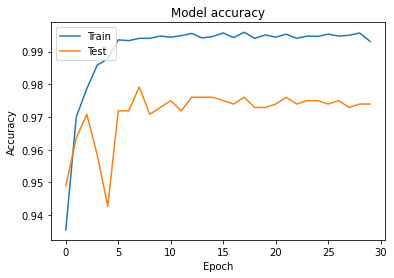

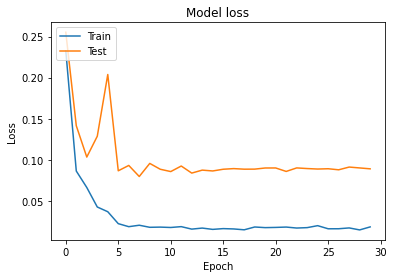

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [48]:
#load saved model
model.load_weights("best_weights.hdf5")

In [49]:
#confusion matrix on the test dataset
from sklearn.metrics import classification_report
y_pred_test = model.predict(test_data)
#reverse labels array, since ImageDataGenerator considered 'NORMAL' label as 1 and 'COVID19' label as 0 
y_pred_test=[1 if np.argmax(i)==0 else 0 for i in y_pred_test]
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.99      0.97      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



# **Kaggle submmission**

In [23]:
#predict labels of kaggle test dataset
y_pred= model.predict(test_imgs_kaggle)

In [24]:
#reverse labels array, since ImageDataGenerator considered 'NORMAL' label as 1 and 'COVID19' label as 0 
y_pred=[1 if np.argmax(i)==0 else 0 for i in y_pred]

In [26]:
#save submission
data = list(zip(img_names_kaggle, y_pred))
submission_df = pd.DataFrame(data, columns=['Image','Label'])
submission_df.head()
submission_df.to_csv("Submission.csv",index=False)